In [1]:
# Imports iniciales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB  # naive bayes
from sklearn.neighbors import KNeighborsClassifier #kNN
from sklearn.svm import SVC  # support vector machine

In [2]:
# Los datos cargados con R, los pasamos a CSV, para luego leerlos con Pandas
casearrest = pd.read_csv('../data/cleaned/casearrest_cl.csv')
compas_failure = pd.read_csv('../data/cleaned/compas_failure_cl.csv')
jailhistory = pd.read_csv('../data/cleaned/jailhistory_cl.csv')
people_charge = pd.read_csv('../data/original/people_charge.csv')
people = pd.read_csv('../data/cleaned/people_cl.csv')
prisonhistory = pd.read_csv('../data/cleaned/prisonhistory_cl.csv')
compas_recid = pd.read_csv('../data/cleaned/compas_recid_cl.csv')
compas_violence = pd.read_csv('../data/cleaned/compas_violence_cl.csv')

# Parámetros a utilizar en GridSearch
tuned_parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],'weights': ['uniform','distance']}
score = 'f1'

Con fin de analizar la etnia se necesita la tabla "people" hasta la columna "is_recid".
Las columnas eliminadas y la razón de esto son las siguientes:
- age: su valor es redundante pues entrega la misma info que 'dob' (date of birth).
- c_offense_date: contiene valores nulos.

Además de dejar el atributos de sexo  y etnia en binario. Al ser los valores de 'race' strings, se reemplazarán por $1$ si es igual a 'African-American' y $0$ en caso contrario.

In [3]:
dataset = people.copy()
dataset = dataset[dataset.columns[0:-9]].drop(columns=['age', 'c_offense_date'])
dataset['sex'] = np.where(dataset['sex']=='Male', 1, 0)
dataset['race'] = np.where(dataset['race']=='African-American', 1, 0)

Formamos la matriz de correlación, donde se pueden observar las relaciones entre los distintos atributos. Con respecto a 'race', se puede distiguir como importante el atributo 'decile_score'.

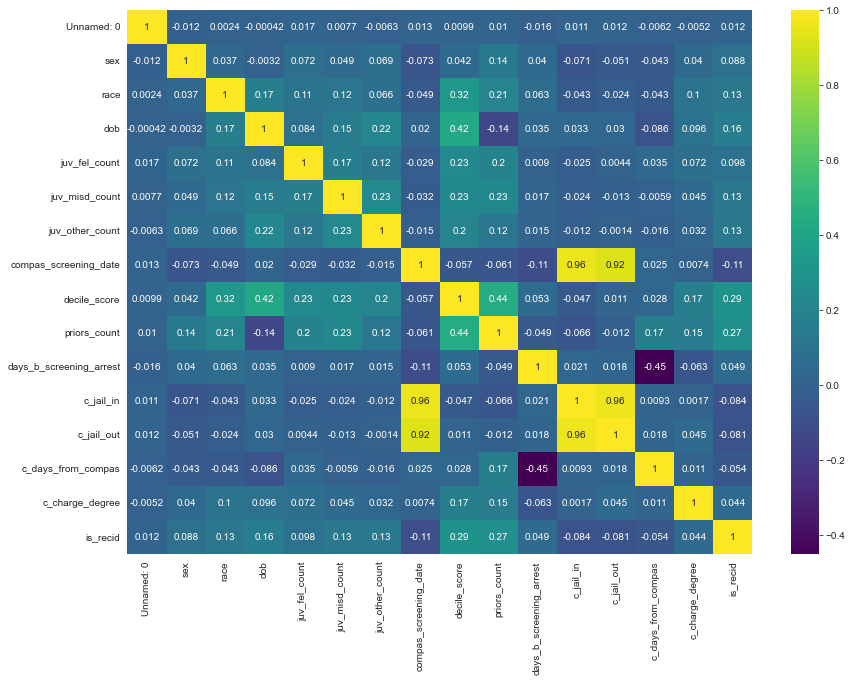

In [4]:
plt.figure(figsize=(14, 10))
sns.heatmap(dataset.corr(method='spearman'), cmap='viridis', annot=True);

Se entrenan modelos usando GridSearch y K-Neighbors, en la base de datos normalizada. No será necesario evaluar con subsampling y oversampling pues la diferencia entre la cantidad de gente afroamericana y la que no, para el estudio, es de solo 17 personas.

In [5]:
norm_dataset = (dataset-dataset.min()) / (dataset.max()-dataset.min())

# Separamos valores
data_train, data_test, y_train, y_test = train_test_split(norm_dataset, norm_dataset['race'], test_size=0.30,
                                                            random_state=15, stratify=norm_dataset['race'])

# Dejamos los datos para trabajar
y_test = data_test.race
X_test = data_test.drop(columns=['race'])
y_orig =data_train.race
X_orig = data_train.drop(columns=['race'])

# Modelo
clf_org = GridSearchCV(KNeighborsClassifier(), param_grid=tuned_parameters, cv=5, scoring=score)
print('ORIG Mejor combinación de parámetros:')
clf_org.fit(X_orig, y_orig)
print(clf_org.best_params_)

y_pred = clf_org.predict(X_test)

print(classification_report(y_test, y_pred))

ORIG Mejor combinación de parámetros:
{'n_neighbors': 10, 'weights': 'distance'}
              precision    recall  f1-score   support

         0.0       0.60      0.62      0.61      1653
         1.0       0.61      0.59      0.60      1646

    accuracy                           0.61      3299
   macro avg       0.61      0.61      0.61      3299
weighted avg       0.61      0.61      0.61      3299



En la matriz de correlación se pueden identificar muchos atributos poco relacionados con 'race'. Se probará el omitir algunos de estos para ver si se obtienen mejores resultados.

Se omitirá primero 'sex', 'compas_screening_date', 'c_jail_in', 'c_jail_out' y 'c_days_from_compas', pues son los datos con la correlación menos significativa.

In [6]:
dataset2 = people.copy()
dataset2 = dataset2[dataset2.columns[0:-9]].drop(columns=['sex', 'age', 'compas_screening_date', 'c_jail_in', 'c_jail_out', 'c_days_from_compas', 'c_offense_date',])
dataset2['race'] = np.where(dataset2['race']=='African-American', 1, 0)

# Separamos valores
data_train, data_test, y_train, y_test = train_test_split(dataset2, dataset2['race'], test_size=0.30,
                                                            random_state=15, stratify=dataset2['race'])

# Dejamos los datos para trabajar
y_test = data_test.race
X_test = data_test.drop(columns=['race'])
y_orig =data_train.race
X_orig = data_train.drop(columns=['race'])

# Modelo
clf_org = GridSearchCV(KNeighborsClassifier(), param_grid=tuned_parameters, cv=5, scoring=score)
print('ORIG Mejor combinación de parámetros:')
clf_org.fit(X_orig, y_orig)
print(clf_org.best_params_)

y_pred = clf_org.predict(X_test)

print(classification_report(y_test, y_pred))

ORIG Mejor combinación de parámetros:
{'n_neighbors': 1, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.53      0.55      0.54      1653
           1       0.53      0.50      0.51      1646

    accuracy                           0.53      3299
   macro avg       0.53      0.53      0.53      3299
weighted avg       0.53      0.53      0.53      3299



Ahora se omitirán todos los atributos cuya correlación con 'race' esté entre $-0.1$ y $0.1$.

In [7]:
dataset3 = people.copy()
dataset3 = dataset3[dataset3.columns[0:-9]].drop(columns=['sex', 'age', 'juv_other_count', 'compas_screening_date', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_days_from_compas', 'c_offense_date', 'c_charge_degree'])
dataset3['race'] = np.where(dataset3['race']=='African-American', 1, 0)

# Separamos valores
data_train, data_test, y_train, y_test = train_test_split(dataset3, dataset3['race'], test_size=0.30,
                                                            random_state=15, stratify=dataset3['race'])

# Dejamos los datos para trabajar
y_test = data_test.race
X_test = data_test.drop(columns=['race'])
y_orig =data_train.race
X_orig = data_train.drop(columns=['race'])

### modelo del original
clf_org = GridSearchCV(KNeighborsClassifier(), param_grid=tuned_parameters, cv=5, scoring=score)
print('ORIG Mejor combinación de parámetros:')
clf_org.fit(X_orig, y_orig)
print(clf_org.best_params_)

y_pred = clf_org.predict(X_test)

print(classification_report(y_test, y_pred))

ORIG Mejor combinación de parámetros:
{'n_neighbors': 1, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.54      0.57      0.55      1653
           1       0.54      0.51      0.53      1646

    accuracy                           0.54      3299
   macro avg       0.54      0.54      0.54      3299
weighted avg       0.54      0.54      0.54      3299



De momento, la Accuracy más alta que se obtuvo fue de $0.61$ al quitar las variables con menos influencia en 'race', pero este resultado aún no es suficiente para ayudar a dar una respueta concisa a la pregunta propuesta.

Se repetiran todos los entrenamientos anteriores, con la diferencia que se utilizará un clasificador de **Decision Tree** con el fin de abordar más posibilidades y así seleccionar el mejor resultado entre ambos clasificadores.

In [8]:
dataset = people.copy()
dataset = dataset[dataset.columns[0:-9]].drop(columns=['age', 'c_offense_date'])
dataset['sex'] = np.where(dataset['sex']=='Male', 1, 0)
dataset['race'] = np.where(dataset['race']=='African-American', 1, 0)

# Parámetros a utilizar en GridSearch-DecisionTree
tuned_parameters = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                    'min_samples_leaf': [1, 2, 3, 4, 5],
                    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                    'criterion': ['gini','entropy']}

Se entrenan modelos usando GridSearch, en la base de datos normalizada.

In [9]:
norm_dataset = (dataset-dataset.min()) / (dataset.max()-dataset.min())

# Separamos valores
data_train, data_test, y_train, y_test = train_test_split(norm_dataset, norm_dataset['race'], test_size=0.30,
                                                        random_state=15, stratify=norm_dataset['race'])

# Dejamos los datos para trabajar
y_test = data_test.race
X_test = data_test.drop(columns=['race'])
y_orig =data_train.race
X_orig = data_train.drop(columns=['race'])

# Modelo
clf_org = GridSearchCV(DecisionTreeClassifier(), param_grid=tuned_parameters, cv=5, scoring=score)
print('ORIG Mejor combinación de parámetros:')
clf_org.fit(X_orig, y_orig)
print(clf_org.best_params_)

y_pred = clf_org.predict(X_test)

print(classification_report(y_test, y_pred))

ORIG Mejor combinación de parámetros:
{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 6}
              precision    recall  f1-score   support

         0.0       0.64      0.59      0.61      1653
         1.0       0.62      0.66      0.64      1646

    accuracy                           0.63      3299
   macro avg       0.63      0.63      0.63      3299
weighted avg       0.63      0.63      0.63      3299



Se realiza otro entrenamiento, omitiendo los parámetros menos significativos: 'sex', 'compas_screening_date', 'c_jail_in', 'c_jail_out' y 'c_days_from_compas'

In [10]:
dataset2 = people.copy()
dataset2 = dataset2[dataset2.columns[0:-9]].drop(columns=['sex', 'age', 'compas_screening_date', 'c_jail_in', 'c_jail_out', 'c_days_from_compas', 'c_offense_date'])
dataset2['race'] = np.where(dataset2['race']=='African-American', 1, 0)

# Separamos valores
data_train, data_test, y_train, y_test = train_test_split(dataset2, dataset2['race'], test_size=0.30,
                                                            random_state=15, stratify=dataset2['race'])

# Dejamos los datos para trabajar
y_test = data_test.race
X_test = data_test.drop(columns=['race'])
y_orig =data_train.race
X_orig = data_train.drop(columns=['race'])

# Modelo
clf_org = GridSearchCV(DecisionTreeClassifier(), param_grid=tuned_parameters, cv=5, scoring=score)
print('ORIG Mejor combinación de parámetros:')
clf_org.fit(X_orig, y_orig)
print(clf_org.best_params_)

y_pred = clf_org.predict(X_test)

print(classification_report(y_test, y_pred))

ORIG Mejor combinación de parámetros:
{'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.63      0.61      0.62      1653
           1       0.62      0.64      0.63      1646

    accuracy                           0.63      3299
   macro avg       0.63      0.63      0.63      3299
weighted avg       0.63      0.63      0.63      3299



Ahora se omitirán todos los atributos cuya correlación con 'race' esté entre $-0.1$ y $0.1$.

In [11]:
dataset3 = people.copy()
dataset3 = dataset3[dataset3.columns[0:-9]].drop(columns=['sex', 'age', 'juv_other_count', 'compas_screening_date', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_days_from_compas', 'c_offense_date', 'c_charge_degree'])
dataset3['race'] = np.where(dataset3['race']=='African-American', 1, 0)

# Separamos valores
data_train, data_test, y_train, y_test = train_test_split(dataset3, dataset3['race'], test_size=0.30,
                                                            random_state=15, stratify=dataset3['race'])

# Dejamos los datos para trabajar
y_test = data_test.race
X_test = data_test.drop(columns=['race'])
y_orig =data_train.race
X_orig = data_train.drop(columns=['race'])

# Modelo
clf_org = GridSearchCV(DecisionTreeClassifier(), param_grid=tuned_parameters, cv=5, scoring=score)
print('ORIG Mejor combinación de parámetros:')
clf_org.fit(X_orig, y_orig)
print(clf_org.best_params_)

y_pred = clf_org.predict(X_test)

print(classification_report(y_test, y_pred))

ORIG Mejor combinación de parámetros:
{'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.62      0.64      0.63      1653
           1       0.63      0.62      0.62      1646

    accuracy                           0.63      3299
   macro avg       0.63      0.63      0.63      3299
weighted avg       0.63      0.63      0.63      3299



Con el cambio de clasificador se notan dos casos sobresalientes. Se obtuvo un Accuracy de $0.63$ al utilizar todos los atributos disponibles y el mismo valor se obtuvo dejando de lado los cinco atributos menos significativos.

En estos experimentos la Accuracy más alta que se obtuvo fue de $0.63$, se llego a este resultado mediante el uso de Decision Tree's haciendo uso de todos los atributos disponibles, sin embargo, también se puede llegar a este valor sin incluir los cinco atributos menos significativos(sex, compas_scrrening_date, c_jail_in, c_jail_out y days_from_compas) y aplicando un Decision Tree.

Volviendo a la pregunta propuesta: **¿Es posible predecir la etnia de una persona en base a atributos del análisis de COMPAS?**
Con las pruebas realizadas *si se podría* dar una respuesta a esta pregunta, sin embargo, esta respuesta no está muy lejos del azar. Se podría ver que entre los atributos que se le suministraron a los entrenamientos hay factores con los que se podría encontrar la raza de la persona, pero dado el valor de accuracy no se considera correcto sostener la afirmación, aunque los resultados obtenidos son mejores que el azar, no son lo suficientemente fuertes para responder afirmativamente la pregunta.

Estas características que logran identificar si una persona es afroamericana o no, existen, pero no con una influencia que nos permita asegurar que, conociendo estas, se pueda estimar con seguridad la etnia de un individuo, pero no se descarta la posibilidad de que con más datos a disposición, el resultado pueda cambiar.